In [1]:
import pennylane as qml
from pennylane import numpy as np
import tensorflow as tf

2023-06-07 14:42:14.122192: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
dev = qml.device('default.mixed', wires=3)

In [3]:
def real(angles,**kwargs):
    qml.Hadamard(wires=0)
    qml.Rot(*angles,wires=0)

In [4]:
drawer = qml.draw(real)
w = ['a', 'b', 'c']
print(drawer(w))

0: ──H──Rot(a,b,c)─┤  


In [5]:
def generator(w,**kwargs):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=1)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=1)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=1)
    qml.CNOT(wires=[0,1])
    qml.RX(w[6], wires=0)
    qml.RY(w[7], wires=0)
    qml.RZ(w[8], wires=0)
    qml.BitFlip(p, wires=0)
    qml.BitFlip(p, wires=1)

In [6]:
drawer = qml.draw(generator,show_all_wires=True,wire_order=[0,1,2])
w = ['w0','w1','w2','w3','w4','w5','w6','w7','w8']
p='p'
#w = ['w0','w1','w2']
print(drawer(w))

0: ──H───────RX(w0)──RY(w2)──RZ(w4)─╭●──RX(w6)──────RY(w7)──RZ(w8)──BitFlip(p)─┤  
1: ──RX(w1)──RY(w3)──RZ(w5)─────────╰X──BitFlip(p)─────────────────────────────┤  
2: ────────────────────────────────────────────────────────────────────────────┤  


In [7]:
def discriminator(w):
    qml.Hadamard(wires=0)
    qml.RX(w[0], wires=0)
    qml.RX(w[1], wires=2)
    qml.RY(w[2], wires=0)
    qml.RY(w[3], wires=2)
    qml.RZ(w[4], wires=0)
    qml.RZ(w[5], wires=2)
    qml.CNOT(wires=[0, 2])
    qml.RX(w[6], wires=2)
    qml.RY(w[7], wires=2)
    qml.RZ(w[8], wires=2)
    qml.BitFlip(p, wires=0)
    qml.BitFlip(p, wires=2)

In [8]:
drawer = qml.draw(discriminator,show_all_wires=True,wire_order=[0,1,2])
w = ['w0','w1','w2','w3','w4','w5','w6','w7','w8']
#w = ['w0','w1','w2']
print(drawer(w))

0: ──H───────RX(w0)──RY(w2)──RZ(w4)─╭●──BitFlip(p)─────────────────────────────┤  
1: ─────────────────────────────────│──────────────────────────────────────────┤  
2: ──RX(w1)──RY(w3)──RZ(w5)─────────╰X──RX(w6)──────RY(w7)──RZ(w8)──BitFlip(p)─┤  


In [9]:
@qml.qnode(dev, interface='tf')
def real_disc_circuit(phi, theta, omega, disc_weights):
    real([phi,theta,omega])
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

@qml.qnode(dev,interface='tf')
def gen_disc_circuit(gen_weights,disc_weights):
    generator(gen_weights)
    discriminator(disc_weights)
    return qml.expval(qml.PauliZ(2))

In [10]:
drawer = qml.draw(real_disc_circuit,show_all_wires=True,wire_order=[0,1,2])
w = ['w0','w1','w2','w3','w4','w5','w6','w7','w8']
#w = ['w0','w1','w2']
p='p'
print(drawer('a', 'b', 'c',w))

0: ──H───────Rot(a,b,c)──H───────RX(w0)──RY(w2)──RZ(w4)─╭●──BitFlip(p)─────────────────────────────┤
1: ─────────────────────────────────────────────────────│──────────────────────────────────────────┤
2: ──RX(w1)──RY(w3)──────RZ(w5)─────────────────────────╰X──RX(w6)──────RY(w7)──RZ(w8)──BitFlip(p)─┤

      
      
   <Z>


In [11]:
drawer = qml.draw(gen_disc_circuit,show_all_wires=True,wire_order=[0,1,2])
w = ['w0','w1','w2','w3','w4','w5','w6','w7','w8']
#w = ['w0','w1','w2']
p='p'
print(drawer(w,w))

0: ──H───────RX(w0)──RY(w2)──RZ(w4)─╭●──RX(w6)──────RY(w7)──RZ(w8)──BitFlip(p)──H──RX(w0)──RY(w2)
1: ──RX(w1)──RY(w3)──RZ(w5)─────────╰X──BitFlip(p)───────────────────────────────────────────────
2: ──RX(w1)──RY(w3)──RZ(w5)──────────────────────────────────────────────────────────────────────

───RZ(w4)─╭●──BitFlip(p)─────────────────────────────┤     
──────────│──────────────────────────────────────────┤     
──────────╰X──RX(w6)──────RY(w7)──RZ(w8)──BitFlip(p)─┤  <Z>


In [12]:
def prob_real_true(disc_weights):
    true_disc_output = real_disc_circuit(phi,theta,omega,disc_weights)
    #convert to probability
    prob_real_true = (true_disc_output+1)/2
    return prob_real_true

In [13]:
def prob_fake_true(gen_weights,disc_weights):
    fake_disc_output = gen_disc_circuit(gen_weights,disc_weights)
    #convert to probability
    prob_fake_true = (fake_disc_output+1)/2
    return prob_fake_true

In [14]:
def disc_cost(disc_weights):
    cost = prob_fake_true(gen_weights,disc_weights)-prob_real_true(disc_weights)
    return cost
def gen_cost(gen_weights):
    cost = -prob_fake_true(gen_weights,disc_weights)
    return cost

In [15]:
ps = [0.001, 0.01, 0.1, 0.2]
phi = np.pi / 6
theta = np.pi / 2
omega = np.pi / 7
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   np.random.normal(scale=eps, size=(9,))

init_disc_weights = np.random.normal(size=(9,))
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

2023-06-07 14:42:35.215108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
p = 0.01
opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)

var = disc_weights
loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1

for step in range(50):
    opt.minimize(loss, [var])
    if step % 5 == 0:
        loss_val = loss().numpy()
        print("Step {}: cost = {}".format(step, loss_val))

Step 0: cost = -0.055469478423124885
Step 5: cost = -0.2532281247347584
Step 10: cost = -0.4149900777997543
Step 15: cost = -0.46199155167881883
Step 20: cost = -0.4738802598917118
Step 25: cost = -0.4793318709505633
Step 30: cost = -0.4827181645328349
Step 35: cost = -0.48489237915053107
Step 40: cost = -0.4862584706234976
Step 45: cost = -0.4870984246252762


In [17]:
opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
var_g = gen_weights
print('var_g =',var_g)

loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
print('loss =',gen_cost(gen_weights))

for step in range(50):
    opt.minimize(loss, [var_g])
    if step % 5 == 0:
        loss_val = loss().numpy()
        print("Step {}: cost = {}".format(step, loss_val))

var_g = <tf.Variable 'Variable:0' shape=(9,) dtype=float64, numpy=
array([ 3.15923318e+00,  4.00157208e-03,  9.78737984e-03,  2.24089320e-02,
        1.86755799e-02, -9.77277880e-03,  9.50088418e-03, -1.51357208e-03,
       -1.03218852e-03])>
loss = tf.Tensor(-0.5009836040606368, shape=(), dtype=float64)
Step 0: cost = -0.5773254485877835
Step 5: cost = -0.8685948537860002
Step 10: cost = -0.9569599638382617
Step 15: cost = -0.974670896300651
Step 20: cost = -0.9791123363542008
Step 25: cost = -0.9804213959173773
Step 30: cost = -0.9808281714281447
Step 35: cost = -0.9809566964069816
Step 40: cost = -0.9809975615007592
Step 45: cost = -0.9810105917477785


In [18]:
print("Prob(fake classified as real): ", prob_fake_true(var_g, var).numpy())

Prob(fake classified as real):  0.9810142517850478


In [19]:
print("Discriminator cost: ", disc_cost(var).numpy())

Discriminator cost:  -0.007494412532056627


In [20]:
obs = [qml.PauliX(0), qml.PauliY(0), qml.PauliZ(0)]

@qml.qnode(dev, interface="tf")
def bloch_vector_real(angles):
    real(angles)
    return [qml.expval(o) for o in obs]

@qml.qnode(dev, interface="tf")
def bloch_vector_generator(angles):
    generator(angles)
    return [qml.expval(o) for o in obs]

print(f"Real Bloch vector: {bloch_vector_real([phi, theta, omega])}")
print()
print(f"Generator Bloch vector: {bloch_vector_generator(var_g)}")

Real Bloch vector: [tensor(-0.21694187, requires_grad=True), tensor(0.45048443, requires_grad=True), tensor(-0.8660254, requires_grad=True)]

Generator Bloch vector: [<tf.Tensor: shape=(), dtype=float64, numpy=-0.29110247013463064>, <tf.Tensor: shape=(), dtype=float64, numpy=0.40761957251317665>, <tf.Tensor: shape=(), dtype=float64, numpy=-0.8443072594988499>]


In [21]:
@qml.qnode(dev, interface="tf")
def circuit_gs(angles):
    generator(angles)
    return qml.state()
@qml.qnode(dev, interface="tf")
def circuit_rs(angles):
    real(angles)
    return qml.state()

In [22]:
qml.math.fidelity(circuit_rs([phi, theta, omega]), circuit_gs(var_g))

<tf.Tensor: shape=(), dtype=float64, numpy=0.05538232933601181>

In [23]:
ps = [0.0, 0.001, 0.01, 0.1]
phi = np.pi / 6
theta = np.pi / 2
omega = np.pi / 7
np.random.seed(0)
eps = 1e-2
init_gen_weights = np.array([np.pi] + [0] * 8) + \
                   np.random.normal(scale=eps, size=(9,))

init_disc_weights = np.random.normal(size=(9,))
gen_weights = tf.Variable(init_gen_weights,dtype=tf.float64)
disc_weights = tf.Variable(init_disc_weights,dtype=tf.float64)

F_b = []
F_s = []

for i in ps:
    opt = tf.keras.optimizers.experimental.SGD(learning_rate=0.4)
    p = i
    var = disc_weights
    loss = lambda: disc_cost(disc_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var])
        if step % 5 == 0:
            loss_val = loss().numpy()
            print("Step {}: cost = {}".format(step, loss_val))
        
    opt = tf.keras.optimizers.legacy.SGD(learning_rate=0.4)
    var_g = gen_weights
    loss = lambda: gen_cost(gen_weights)         # d(loss)/d(var1) = var1
    for step in range(50):
        opt.minimize(loss, [var_g])
        if step % 5 == 0:
            loss_val = loss().numpy()
            print("Step {}: cost = {}".format(step, loss_val))    
    red_r = qml.math.reduced_dm(circuit_rs([phi, theta, omega]),indices=[0])
    red_g = qml.math.reduced_dm(circuit_gs(var_g),indices=[0])
    state_fidelity = qml.math.fidelity(red_r, red_g)
    bloch_vector_fidelity = qml.math.fidelity(bloch_vector_real([phi, theta, omega]), bloch_vector_generator(var_g))
    F_s.append( state_fidelity)
    F_b.append( bloch_vector_fidelity)

Step 0: cost = -0.05727697679579291
Step 5: cost = -0.2634812508449125
Step 10: cost = -0.42739188533175787
Step 15: cost = -0.4726159748418687
Step 20: cost = -0.4840689974053145
Step 25: cost = -0.48946413443471104
Step 30: cost = -0.49281877884753467
Step 35: cost = -0.4949493282586541
Step 40: cost = -0.4962703876869824
Step 45: cost = -0.4970720262026571
Step 0: cost = -0.5833387118384168
Step 5: cost = -0.8915733598437553
Step 10: cost = -0.9784243532820139
Step 15: cost = -0.9946483809432254
Step 20: cost = -0.9984996426172696
Step 25: cost = -0.999563846400684
Step 30: cost = -0.9998717844534892
Step 35: cost = -0.9999621462112538
Step 40: cost = -0.9999888012418668
Step 45: cost = -0.99999668250241
Step 0: cost = 0.0003382197439346646
Step 5: cost = -0.0004003492094766248
Step 10: cost = -0.0010992242024825405
Step 15: cost = -0.0017676968184608954
Step 20: cost = -0.002415195479697485
Step 25: cost = -0.0030511390834824237
Step 30: cost = -0.0036848183680038282
Step 35: cost 

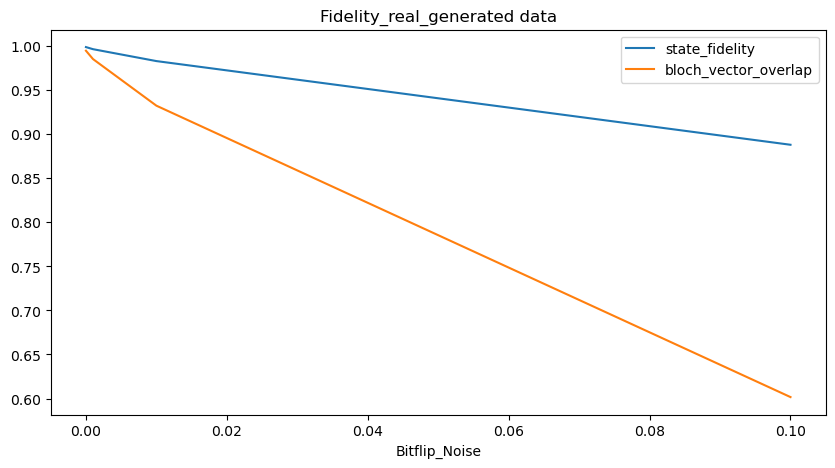

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(ps, F_s, label="state_fidelity")
plt.plot(ps, F_b, label="bloch_vector_overlap")
plt.title("Fidelity_real_generated data")
plt.xlabel("Bitflip_Noise")
plt.legend()
plt.show()